# Préparer des données DataBlocks

In [2]:
# Chargement de la librairie.
from fastai2.vision.all import *

In [3]:
# Fonction permettant de découper le nom des images pour en ressortir le label race (RACE_0000.jpg)
def get_label_from_filename(filename):
    return re.findall(r'(.+)_\d+.jpg$', filename)

In [4]:
# On récupére le jeux de données proposé par FastAI (URLs.PETS = https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz)
path = untar_data(URLs.PETS)
images_list = (path/"images").ls()

In [5]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock), # On a des images en entrée et des catégories en sortie 
                 get_items=get_image_files, # Méthode de récupération d'image
                 splitter=RandomSplitter(seed=42),  # Le dispatch entre jeux d'entrainement et jeux de validation est aléatoire
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),  # On utilise une expression régulière pour définir le label
                 item_tfms=Resize(460),  # On retaille les images 
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))  # Description des mini-batchs. 

# La fonction aug_transforms permet d'augmenter la variété des exemples en transformant un petit peu l'image. Par défaut elle 
# applique les modifications AffineCoord (Rotation), Lighting (luminosité et contraste) et RandomResizedCroGPU (Zoom au hasard). 
# Cela permet de démultiplier le nombre d'image et donc de données d'entrainement. 

# La méthode summmary (pets.summarry(path/"images")) permet de voir ce que fait le DataBlock pour se rendre compte des problèmes.

dls = pets.dataloaders(path/"images")

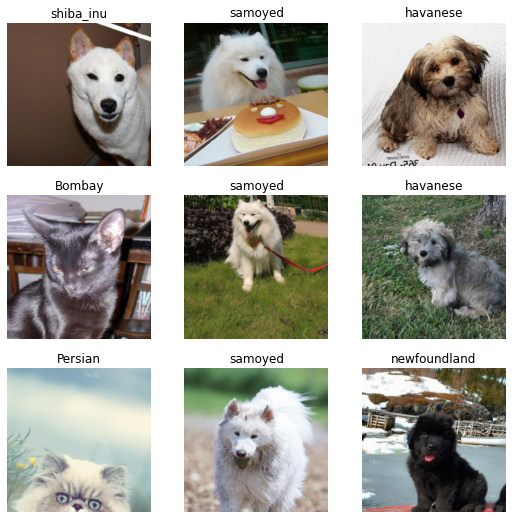

In [6]:
dls.show_batch()

In [7]:
# On peut dés maintenant entrainer un modèle (un peu au pif) pour avoir une première idée.
# La fonction de coût a été déterminé automatiquement par le Framework basé sur notre utilisation de CategoryBlock.

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.527195,0.315075,0.105548,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.523514,0.373086,0.112991,00:39
1,0.328220,0.254821,0.077131,00:39


In [8]:
x,y = dls.one_batch()
print("Deux tensors de 64 (taille du batch) x avec des images de 224 par 224 (en 3 couleurs) et y avec le resultat", x.shape, y.shape)

print("dls.vocab permet de récupérer le nom des labels", y[0].item(), dls.vocab[y[0]])

preds,_ = learn.get_preds(dl=[(x,y)])

# Les nombres ont été ramené entre 0 et 1 par la fonction sigmoid. 
print("Pour chaque image on a 37 nombres en sortie. Un par label possible. Est-ce le label1, est-ce le label 2, ...", preds.shape)
preds[0]

Deux tensors de 64 (taille du batch) x avec des images de 224 par 224 (en 3 couleurs) et y avec le resultat torch.Size([64, 3, 224, 224]) torch.Size([64])
dls.vocab permet de récupérer le nom des labels 23 japanese_chin


Pour chaque image on a 37 nombres en sortie. Un par label possible. Est-ce le label1, est-ce le label 2, ... torch.Size([64, 37])


tensor([1.5631e-08, 2.9778e-07, 9.6969e-06, 1.2807e-06, 3.3843e-07, 9.2362e-07,
        1.1941e-05, 1.8636e-06, 2.4396e-06, 2.0646e-08, 5.0295e-07, 6.2141e-07,
        1.5045e-07, 1.1805e-07, 2.9172e-05, 6.5735e-07, 4.8757e-07, 1.7228e-06,
        4.8108e-06, 1.6131e-05, 3.2051e-06, 3.5605e-06, 3.8509e-04, 9.9926e-01,
        6.5283e-05, 1.4706e-06, 1.3381e-07, 2.3488e-05, 5.5979e-05, 6.6644e-05,
        3.6360e-05, 6.5628e-07, 5.9662e-07, 6.3478e-08, 7.0166e-08, 9.9312e-08,
        1.4627e-05])

# Interpretation du résultat

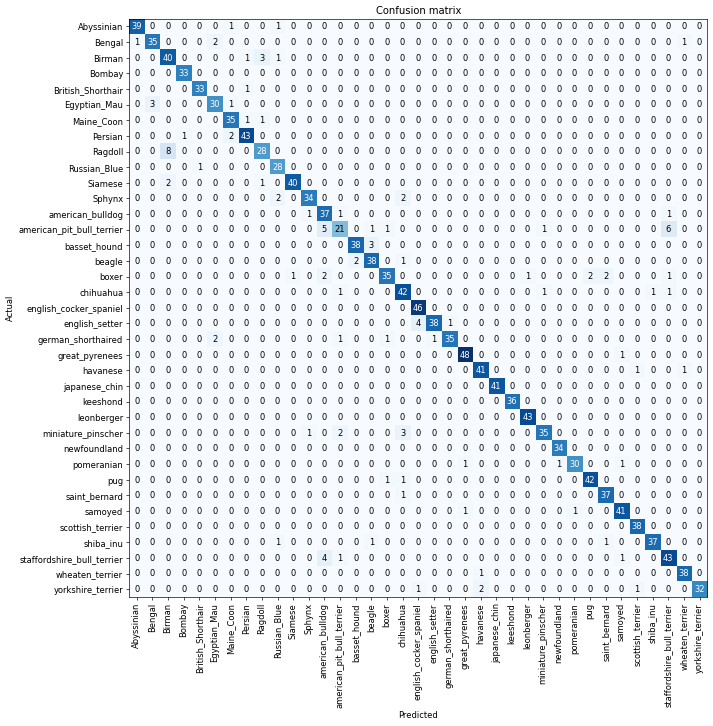

In [9]:
# Afficher la matrice de confusion
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [10]:
# Affichage des couples les plus confondus entre eux

interp.most_confused(min_val=6)

[('Ragdoll', 'Birman', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6)]

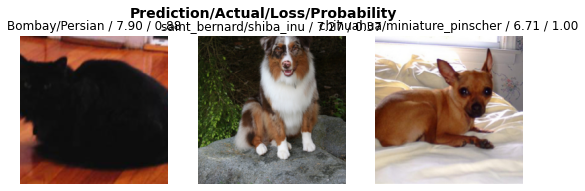

In [11]:
# Affichage des plus grandes erreurs (on était sur d'un truc et c'était pas ça)

interp.plot_top_losses(k=3)

# Amélioration du modèle

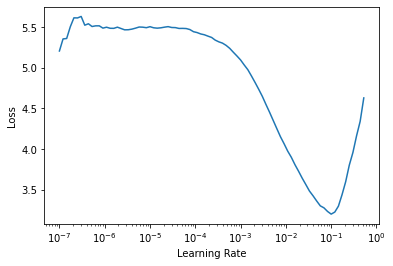

In [12]:
# Une méthode existe pour essayer de trouver le bon learning rate. Le principe est assez simple, l'entrainement est réalisé 
# avec un learning rate de plus en plus grand et on regarde l'impact que cela a sur le résultat (fonction de cout)
# On va chercher à trouver l'endroit ou la "pente" (l'amélioration) est la plus grande

learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_step = learn.lr_find()

In [13]:
# Le "steepest point" est fourni par fastAi en sortie de la méthode lr_find. On peut s'en servir pour ré-entrainer notre modèle
# Le premier entrainement était bon car fastAi le fait seul pour les cas simples. 

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=lr_step)

epoch,train_loss,valid_loss,error_rate,time
0,1.054038,0.348758,0.100812,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.678938,0.462681,0.129905,00:38
1,0.384088,0.286087,0.092016,00:38


In [14]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 0.006) 

epoch,train_loss,valid_loss,error_rate,time
0,0.998953,0.615364,0.183356,00:33
1,0.594700,0.380188,0.100812,00:33
2,0.355957,0.273047,0.081867,00:33


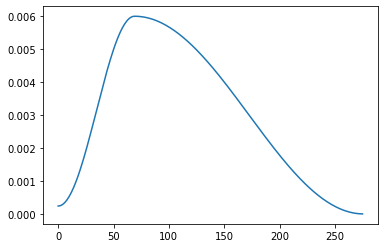

In [15]:
# Dans les fait la learning rate appliquée n'est pas constante (lr_sep = 0.006 ici). FastAI en réalité ajuste ce paramètre 
# au fil du temps

lrs=learn.recorder.lrs # le framework a enregistré ce qu'il faisait
plt.plot((list(range(len(lrs)))), lrs, label='lr') # On affiche la courbe du learning rate qui "passe" par 0.006

In [16]:
# Le model pytorh est en 2 niveaux (body et head voir le cours). 

[(name, type(module)) for name,module in learn.model.named_children()]

[('0', torch.nn.modules.container.Sequential),
 ('1', torch.nn.modules.container.Sequential)]

In [17]:
# La première partie (body) est composée de 4 blocs pour initié mon réseau de neurones puis 4 blocs similaires (Sequential) 
# qui ce succèdent

[(name, type(module)) for name,module in list(learn.model.children())[0].named_children()]

[('0', torch.nn.modules.conv.Conv2d),
 ('1', torch.nn.modules.batchnorm.BatchNorm2d),
 ('2', torch.nn.modules.activation.ReLU),
 ('3', torch.nn.modules.pooling.MaxPool2d),
 ('4', torch.nn.modules.container.Sequential),
 ('5', torch.nn.modules.container.Sequential),
 ('6', torch.nn.modules.container.Sequential),
 ('7', torch.nn.modules.container.Sequential)]

In [18]:
# La deuxième partie (head) est composée différement

[(name, type(module)) for name,module in list(learn.model.children())[1].named_children()]

[('0', fastai2.layers.AdaptiveConcatPool2d),
 ('1', fastai2.layers.Flatten),
 ('2', torch.nn.modules.batchnorm.BatchNorm1d),
 ('3', torch.nn.modules.dropout.Dropout),
 ('4', torch.nn.modules.linear.Linear),
 ('5', torch.nn.modules.activation.ReLU),
 ('6', torch.nn.modules.batchnorm.BatchNorm1d),
 ('7', torch.nn.modules.dropout.Dropout),
 ('8', torch.nn.modules.linear.Linear)]

# A reprendre

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0004786300996784121)

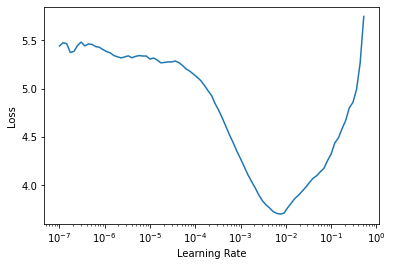

In [19]:
# On appel la méthode unfreeze pour entrainer la partie body de mon modèle. 
# On va chercher à nouveau le bon learning rate pour cette partie 

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.unfreeze()
learn.lr_find()